In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
!pip install tensorflow

In [ ]:
# Đọc dữ liệu từ file CSV
# Thay đổi đường dẫn nếu file được lưu ở vị trí khác
df = pd.read_csv('/content/VFS_clean.csv')

# Chuyển cột Date thành định dạng datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sắp xếp dữ liệu theo ngày
df = df.sort_values('Date')

# Chọn cột Close để dự báo
data = df[['Close']].values

# Chuẩn hóa dữ liệu (cho LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tạo tập dữ liệu cho dự báo
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Số bước thời gian (time steps) cho LSTM
time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape dữ liệu cho LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=1)

# Dự báo
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Đưa dữ liệu dự báo về giá trị ban đầu (khử chuẩn hóa)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0047 - val_loss: 9.7305e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0042 - val_loss: 2.1601e-05
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0030 - val_loss: 2.8836e-05
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0018 - val_loss: 5.3358e-05
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0018 - val_loss: 1.4064e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0029 - val_loss: 4.8309e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0025 - val_loss: 3.9889e-06
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0011 - val_loss: 2.4854e-06
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0024 - val_loss: 1.8116e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0012 - val_loss: 4.9868e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0035 - val_loss: 4.7447e-04
Epoch 12/100
18/18 ━

Train MSE: 5.385582361661757
Test MSE: 0.011549054901004508


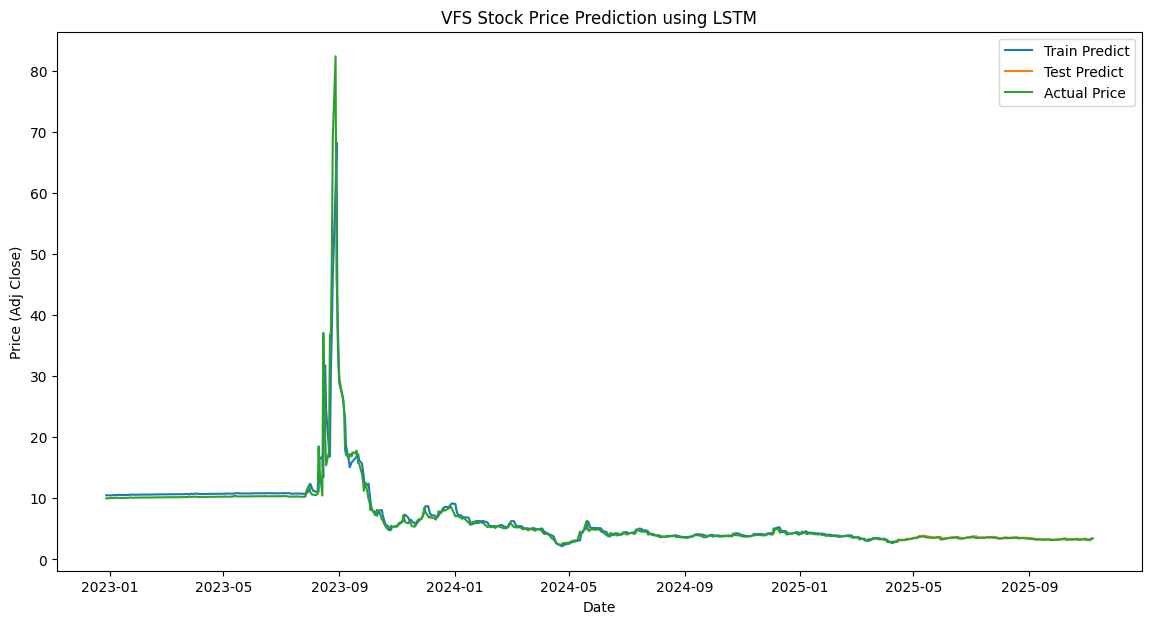

In [ ]:
# Tính toán MSE
train_mse = mean_squared_error(y_train_inv.T, train_predict)
test_mse = mean_squared_error(y_test_inv.T, test_predict)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Vẽ biểu đồ giá thực tế và dự báo
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][time_step:len(train_predict) + time_step], train_predict, label='Train Predict')
plt.plot(df['Date'][len(train_predict) + time_step:len(train_predict) + time_step + len(test_predict)], test_predict, label='Test Predict')
plt.plot(df['Date'][time_step:], scaler.inverse_transform(scaled_data[time_step:]), label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Adj Close)')
plt.title('VFS Stock Price Prediction using LSTM')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

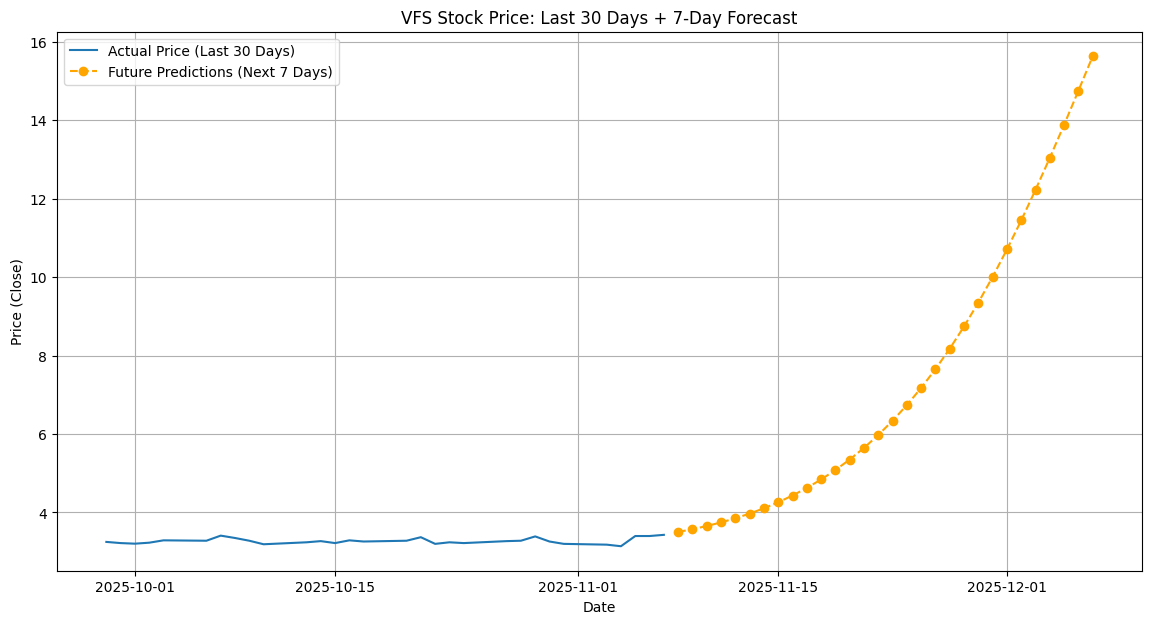

In [ ]:
future_days = 30
last_sequence = scaled_data[-time_step:]
future_predictions = []

for _ in range(future_days):
    last_sequence_reshaped = last_sequence.reshape((1, time_step, 1))
    next_pred = model.predict(last_sequence_reshaped)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_date = df['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=x) for x in range(1, future_days + 1)]

zoom_days = 30
zoom_start = df['Date'].iloc[-zoom_days:]

recent_actual_dates = df['Date'].iloc[-zoom_days:]
recent_actual_prices = scaler.inverse_transform(scaled_data[-zoom_days:])

plt.figure(figsize=(14, 7))
plt.plot(recent_actual_dates, recent_actual_prices, label='Actual Price (Last 30 Days)')
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 7 Days)', marker='o', linestyle='--', color='orange')

plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.title('VFS Stock Price: Last 30 Days + 7-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()


Random Forest Train MSE: 0.9470224492621672
Random Forest Test MSE: 0.017656591127640675


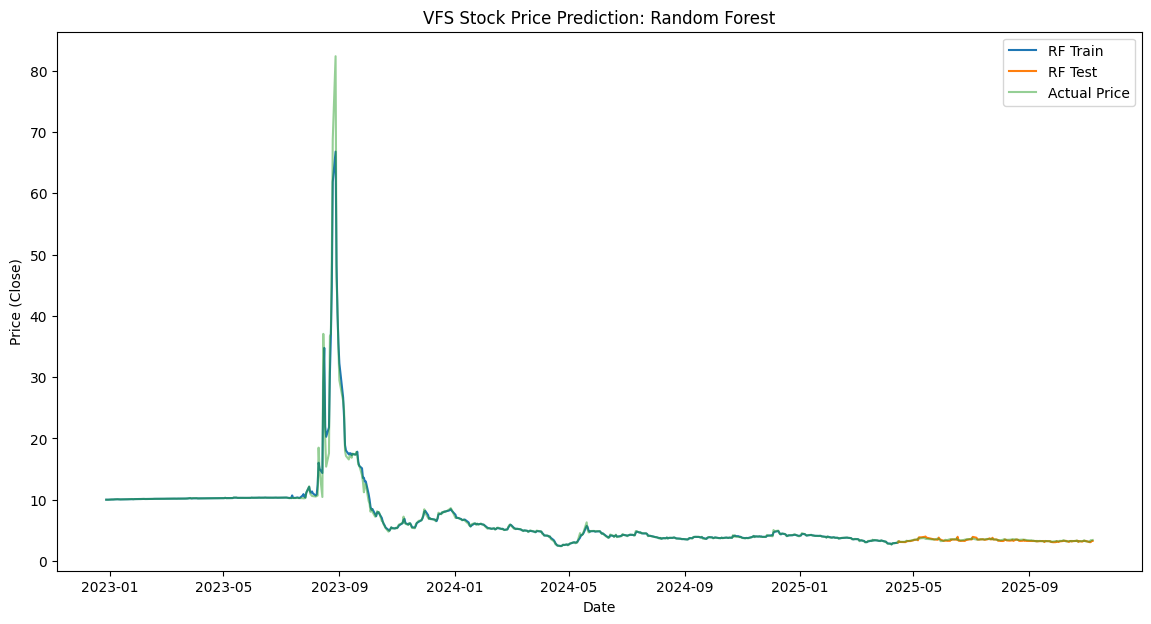

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Chia dữ liệu train/test cho RF (dùng cùng X, y nhưng reshape thành 2D)
X_rf = X.reshape(X.shape[0], X.shape[1])  # RF cần input 2D
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, shuffle=False)

# Tạo mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Dự báo
train_predict_rf = rf_model.predict(X_train_rf)
test_predict_rf = rf_model.predict(X_test_rf)

# Khử chuẩn hóa
train_predict_rf_inv = scaler.inverse_transform(train_predict_rf.reshape(-1, 1))
test_predict_rf_inv = scaler.inverse_transform(test_predict_rf.reshape(-1, 1))
y_train_rf_inv = scaler.inverse_transform(y_train_rf.reshape(-1, 1))
y_test_rf_inv = scaler.inverse_transform(y_test_rf.reshape(-1, 1))

# Tính MSE
train_mse_rf = mean_squared_error(y_train_rf_inv, train_predict_rf_inv)
test_mse_rf = mean_squared_error(y_test_rf_inv, test_predict_rf_inv)
print(f'Random Forest Train MSE: {train_mse_rf}')
print(f'Random Forest Test MSE: {test_mse_rf}')

# Vẽ biểu đồ so sánh LSTM và RF
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][time_step:len(train_predict_rf_inv) + time_step], train_predict_rf_inv, label='RF Train')
plt.plot(df['Date'][len(train_predict_rf_inv) + time_step:len(train_predict_rf_inv) + time_step + len(test_predict_rf_inv)], test_predict_rf_inv, label='RF Test')
plt.plot(df['Date'][time_step:], scaler.inverse_transform(scaled_data[time_step:]), label='Actual Price', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.title('VFS Stock Price Prediction: Random Forest')
plt.legend()
plt.show()


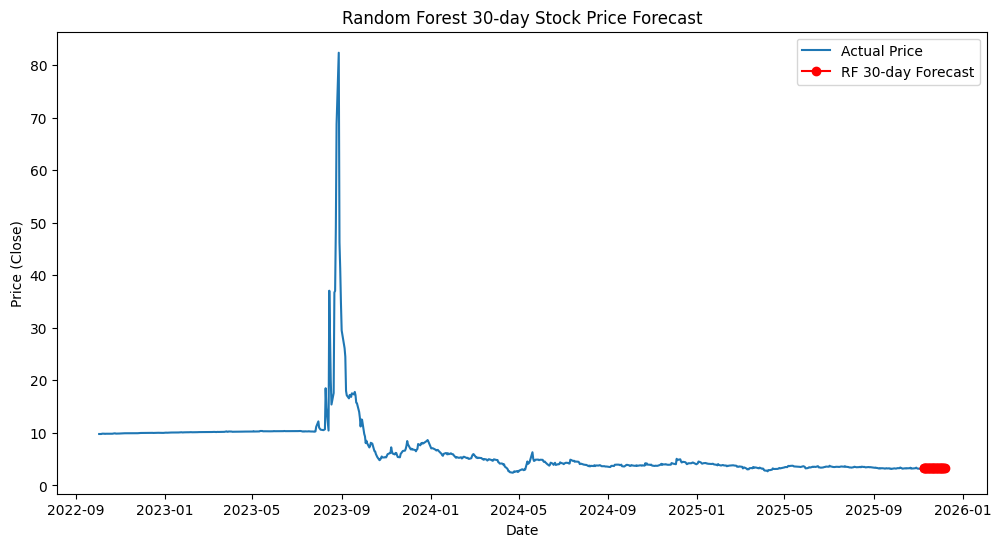

In [ ]:
# Dự báo 7 ngày tiếp theo
future_days = 30
last_data = X_rf[-1]  # Lấy time_step giá cuối cùng
future_predictions = []

current_input = last_data.copy()

for i in range(future_days):
    pred = rf_model.predict(current_input.reshape(1, -1))[0]
    future_predictions.append(pred)

    # Cập nhật input: loại bỏ giá cũ nhất, thêm giá mới dự đoán
    current_input = np.append(current_input[1:], pred)

# Khử chuẩn hóa
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Tạo danh sách ngày dự đoán tiếp theo
last_date = df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(future_days)]

# Vẽ biểu đồ dự báo
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(future_dates, future_predictions_inv, marker='o', color='red', label='RF 30-day Forecast')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.title('Random Forest 30-day Stock Price Forecast')
plt.legend()
plt.show()


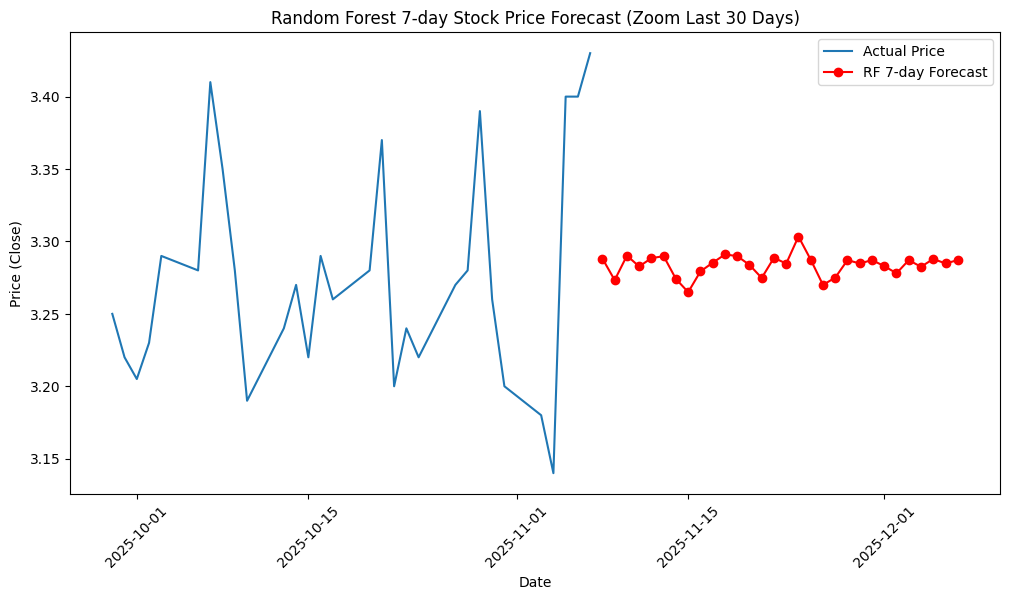

In [ ]:
# Lấy 30 ngày cuối cùng từ dữ liệu gốc để zoom
zoom_days = 30
zoom_start_idx = -zoom_days  # lấy 30 ngày cuối

# Tạo danh sách ngày hiển thị: 30 ngày + 30 ngày dự báo
plot_dates = list(df['Date'].iloc[zoom_start_idx:]) + future_dates
plot_prices = np.concatenate([
    scaler.inverse_transform(scaled_data[zoom_start_idx:]),  # 30 ngày cuối
    future_predictions_inv  # 30 ngày dự báo
])

# Vẽ biểu đồ zoom
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[zoom_start_idx:], scaler.inverse_transform(scaled_data[zoom_start_idx:]), label='Actual Price')
plt.plot(future_dates, future_predictions_inv, marker='o', color='red', label='RF 7-day Forecast')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.title('Random Forest 7-day Stock Price Forecast (Zoom Last 30 Days)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- LSTM ---
# Train
train_mse_lstm = mean_squared_error(y_train_inv.T, train_predict)
train_rmse_lstm = np.sqrt(train_mse_lstm)
train_mae_lstm = mean_absolute_error(y_train_inv.T, train_predict)
train_r2_lstm = r2_score(y_train_inv.T, train_predict)

# Test
test_mse_lstm = mean_squared_error(y_test_inv.T, test_predict)
test_rmse_lstm = np.sqrt(test_mse_lstm)
test_mae_lstm = mean_absolute_error(y_test_inv.T, test_predict)
test_r2_lstm = r2_score(y_test_inv.T, test_predict)

# --- Random Forest ---
# Train
train_mse_rf = mean_squared_error(y_train_rf_inv, train_predict_rf_inv)
train_rmse_rf = np.sqrt(train_mse_rf)
train_mae_rf = mean_absolute_error(y_train_rf_inv, train_predict_rf_inv)
train_r2_rf = r2_score(y_train_rf_inv, train_predict_rf_inv)

# Test
test_mse_rf = mean_squared_error(y_test_rf_inv, test_predict_rf_inv)
test_rmse_rf = np.sqrt(test_mse_rf)
test_mae_rf = mean_absolute_error(y_test_rf_inv, test_predict_rf_inv)
test_r2_rf = r2_score(y_test_rf_inv, test_predict_rf_inv)

# In kết quả
print("=== Model Evaluation ===")
print("LSTM:")
print(f" Train -> MSE: {train_mse_lstm:.5f}, RMSE: {train_rmse_lstm:.5f}, MAE: {train_mae_lstm:.5f}, R2: {train_r2_lstm:.5f}")
print(f" Test  -> MSE: {test_mse_lstm:.5f}, RMSE: {test_rmse_lstm:.5f}, MAE: {test_mae_lstm:.5f}, R2: {test_r2_lstm:.5f}")
print("\nRandom Forest:")
print(f" Train -> MSE: {train_mse_rf:.5f}, RMSE: {train_rmse_rf:.5f}, MAE: {train_mae_rf:.5f}, R2: {train_r2_rf:.5f}")
print(f" Test  -> MSE: {test_mse_rf:.5f}, RMSE: {test_rmse_rf:.5f}, MAE: {test_mae_rf:.5f}, R2: {test_r2_rf:.5f}")


=== Model Evaluation ===
LSTM:
 Train -> MSE: 5.38558, RMSE: 2.32069, MAE: 0.65644, R2: 0.87821
 Test  -> MSE: 0.01155, RMSE: 0.10747, MAE: 0.08521, R2: 0.52083

Random Forest:
 Train -> MSE: 0.94702, RMSE: 0.97315, MAE: 0.20664, R2: 0.97858
 Test  -> MSE: 0.01766, RMSE: 0.13288, MAE: 0.10156, R2: 0.26742


In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta

# 1. Dữ liệu thực tế + dự báo tháng 11 có sẵn (5 ngày)
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
max_year = df_forecast['Date'].dt.year.max()
df_nov_actual = df_forecast[(df_forecast['Date'].dt.month == 11) & (df_forecast['Date'].dt.year == max_year)]

# 2. Dự báo 30 ngày tiếp theo đã tạo từ RF và LSTM (future_dates, future_predictions_inv, future_predictions)
# Giả sử bạn đã có:
# future_dates : list ngày tiếp theo 30 ngày
# future_predictions_inv : dự báo RF đã khử chuẩn
# future_predictions : dự báo LSTM đã khử chuẩn

# Tạo dataframe dự báo 30 ngày tiếp theo
df_future = pd.DataFrame({
    'Date': future_dates,
    'y_true': [''] * len(future_dates),  # để trống vì chưa có giá thực tế
    'y_pred_rf': future_predictions_inv.flatten(),
    'y_pred_lstm': future_predictions.flatten()
})

# 3. Gộp dữ liệu thực tế tháng 11 với dự báo tương lai
df_full = pd.concat([df_nov_actual, df_future], ignore_index=True)

# 4. In ra xem kết quả (chỉ in 35 dòng đầu tiên thôi để không quá dài)
print(df_full[['Date', 'y_true', 'y_pred_rf', 'y_pred_lstm']].head(35))

# Nếu muốn, lưu ra file CSV
df_full.to_csv('VFS_forecast_Nov_and_future.csv', index=False)


         Date y_true  y_pred_rf  y_pred_lstm
0  2025-11-03   3.18    3.12025     3.293739
1  2025-11-04   3.14    3.08825     3.233958
2  2025-11-05    3.4    3.08330     3.181358
3  2025-11-06    3.4    3.27240     3.325849
4  2025-11-07   3.43    3.28820     3.434974
5  2025-11-08           3.28820     3.502516
6  2025-11-09           3.27330     3.574183
7  2025-11-10           3.29020     3.654975
8  2025-11-11           3.28270     3.747016
9  2025-11-12           3.28850     3.852015
10 2025-11-13           3.28980     3.971526
11 2025-11-14           3.27410     4.107050
12 2025-11-15           3.26500     4.260111
13 2025-11-16           3.27930     4.432319
14 2025-11-17           3.28530     4.625414
15 2025-11-18           3.29100     4.841290
16 2025-11-19           3.28990     5.081998
17 2025-11-20           3.28380     5.349727
18 2025-11-21           3.27480     5.646782
19 2025-11-22           3.28870     5.975543
20 2025-11-23           3.28470     6.338415
21 2025-11

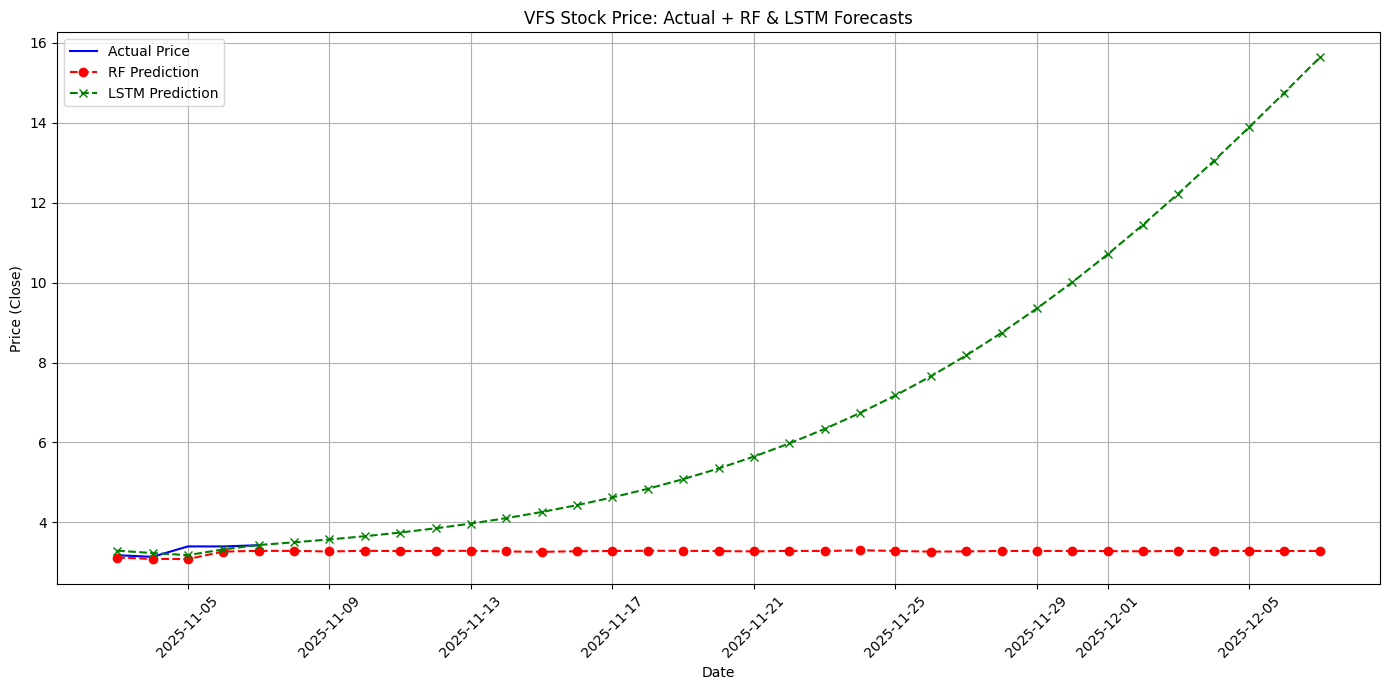

In [ ]:
import matplotlib.pyplot as plt

# Chuyển 'Date' thành datetime nếu chưa
df_full['Date'] = pd.to_datetime(df_full['Date'])

plt.figure(figsize=(14, 7))

# Vẽ giá thực tế (có dữ liệu) - bỏ qua ô trống y_true
mask_actual = df_full['y_true'] != ''
plt.plot(df_full.loc[mask_actual, 'Date'], df_full.loc[mask_actual, 'y_true'], label='Actual Price', color='blue')

# Vẽ dự báo RF
plt.plot(df_full['Date'], df_full['y_pred_rf'], label='RF Prediction', color='red', linestyle='--', marker='o')

# Vẽ dự báo LSTM
plt.plot(df_full['Date'], df_full['y_pred_lstm'], label='LSTM Prediction', color='green', linestyle='--', marker='x')

plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.title('VFS Stock Price: Actual + RF & LSTM Forecasts')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
